In [195]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [196]:
df = pd.read_csv('data/klines_2017_2022.csv')
open_time = df.pop('OpenTime').apply(lambda x: datetime.datetime.fromtimestamp(int(x / 1000)))
close_time = df.pop('CloseTime').apply(lambda x: datetime.datetime.fromtimestamp(int(x / 1000)))

In [197]:
df.head()

,Open,High,Low,Close,Volume,QuoteAssetVolume,NumberOfTrades,TakerBuyBaseAssetVolume,TakerBuyQuoteAssetVolume
0,4261.48,4485.39,4200.74,4285.08,795.15040,3454770.0,3427,616.24854,2678216.5
1,4285.08,4371.52,3938.77,4108.37,1199.88830,5086958.5,5233,972.86870,4129123.2
2,4108.37,4184.69,3850.00,4139.98,381.30975,1549483.8,2153,274.33603,1118001.9
3,4120.98,4211.08,4032.62,4086.29,467.08300,1930364.4,2321,376.79596,1557401.4
4,4069.13,4119.62,3911.79,4016.00,691.74304,2797231.8,3972,557.35610,2255662.5


In [198]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,1759.0,1.936750e+04,1.765875e+04,3188.01000,6.983280e+03,9.706000e+03,3.469196e+04,6.752582e+04
High,1759.0,1.992710e+04,1.814550e+04,3276.50000,7.221680e+03,9.950000e+03,3.611886e+04,6.900000e+04
Low,1759.0,1.872609e+04,1.709244e+04,2817.00000,6.761000e+03,9.421670e+03,3.331160e+04,6.622240e+04
Close,1759.0,1.938170e+04,1.765667e+04,3189.02000,6.997340e+03,9.713990e+03,3.468474e+04,6.752583e+04
Volume,1759.0,5.048715e+04,3.583821e+04,228.10806,2.895741e+04,4.360084e+04,6.401842e+04,4.022017e+05
QuoteAssetVolume,1759.0,1.123754e+09,1.389420e+09,977865.75000,2.314125e+08,4.697467e+08,1.667967e+09,1.347769e+10
NumberOfTrades,1759.0,7.951130e+05,7.470833e+05,2153.00000,2.311940e+05,5.220620e+05,1.187380e+06,6.331062e+06
TakerBuyBaseAssetVolume,1759.0,2.510968e+04,1.738444e+04,56.19014,1.478486e+04,2.174317e+04,3.164363e+04,1.975120e+05
TakerBuyQuoteAssetVolume,1759.0,5.548132e+08,6.798186e+08,241363.80000,1.189918e+08,2.334353e+08,8.299198e+08,6.410033e+09


In [199]:
df = df.iloc[:, :5]

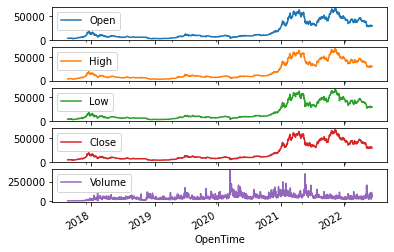

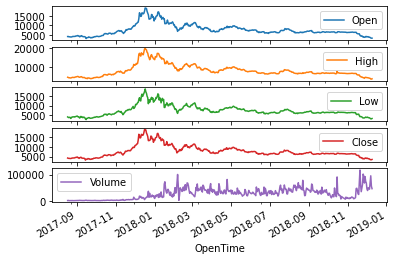

In [200]:
plot_features = df
plot_features.index = open_time
_ = plot_features.plot(subplots=True)

plot_features = df[:480]
plot_features.index = open_time[:480]
_ = plot_features.plot(subplots=True)

In [201]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [202]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

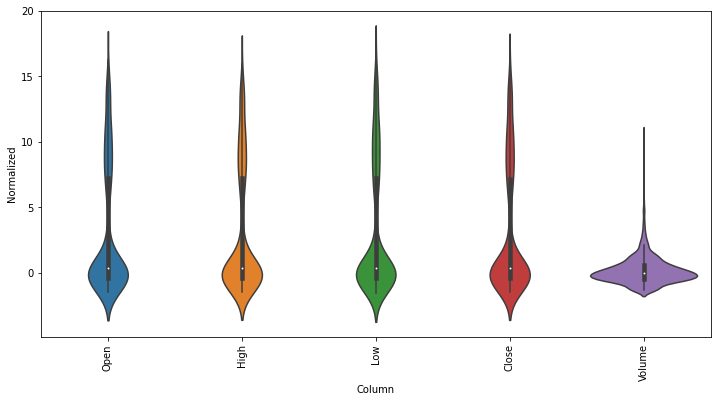

In [203]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [204]:
train_df

,Open,High,Low,Close,Volume
OpenTime,,,,,
2017-08-17 07:00:00,-1.168617,-1.130459,-1.157252,-1.155407,-1.299987
2017-08-18 07:00:00,-1.162118,-1.160619,-1.232559,-1.203579,-1.287952
2017-08-19 07:00:00,-1.210786,-1.210102,-1.258077,-1.194962,-1.312293
2017-08-20 07:00:00,-1.207313,-1.203112,-1.205581,-1.209598,-1.309742
2017-08-21 07:00:00,-1.221593,-1.227336,-1.240315,-1.228759,-1.303062
...,...,...,...,...,...
2020-12-25 07:00:00,4.192964,4.247341,4.371533,4.413226,1.040962
2020-12-26 07:00:00,4.463826,4.797497,4.678087,4.898716,1.584729
2020-12-27 07:00:00,4.954315,5.209343,5.023045,4.840997,3.090823


In [205]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in 
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift #48

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [206]:
w = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['Close'])
w.column_indices

{'Open': 0, 'High': 1, 'Low': 2, 'Close': 3, 'Volume': 4}

In [207]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        
    tf.ensure_shape(inputs, [None, self.input_width, None])
    tf.ensure_shape(labels, [None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [208]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w.total_window_size]),
                           np.array(train_df[100:100+w.total_window_size]),
                           np.array(train_df[200:200+w.total_window_size])])

example_inputs, example_labels = w.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 5)
Inputs shape: (3, 6, 5)
Labels shape: (3, 1, 1)


In [209]:
w.example = example_inputs, example_labels

In [256]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8), dpi=200)
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    idx_to_plot = [0, len(inputs) - 1]
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], 
                 marker='.', label='Inputs')
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], 
                        marker='X', edgecolors='k', label='Predictions', 
                        c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
    plt.xlabel('Time [h]')
    
WindowGenerator.plot=plot

In [253]:
train_df.iloc[:, 3].min()

-1.454199328561302

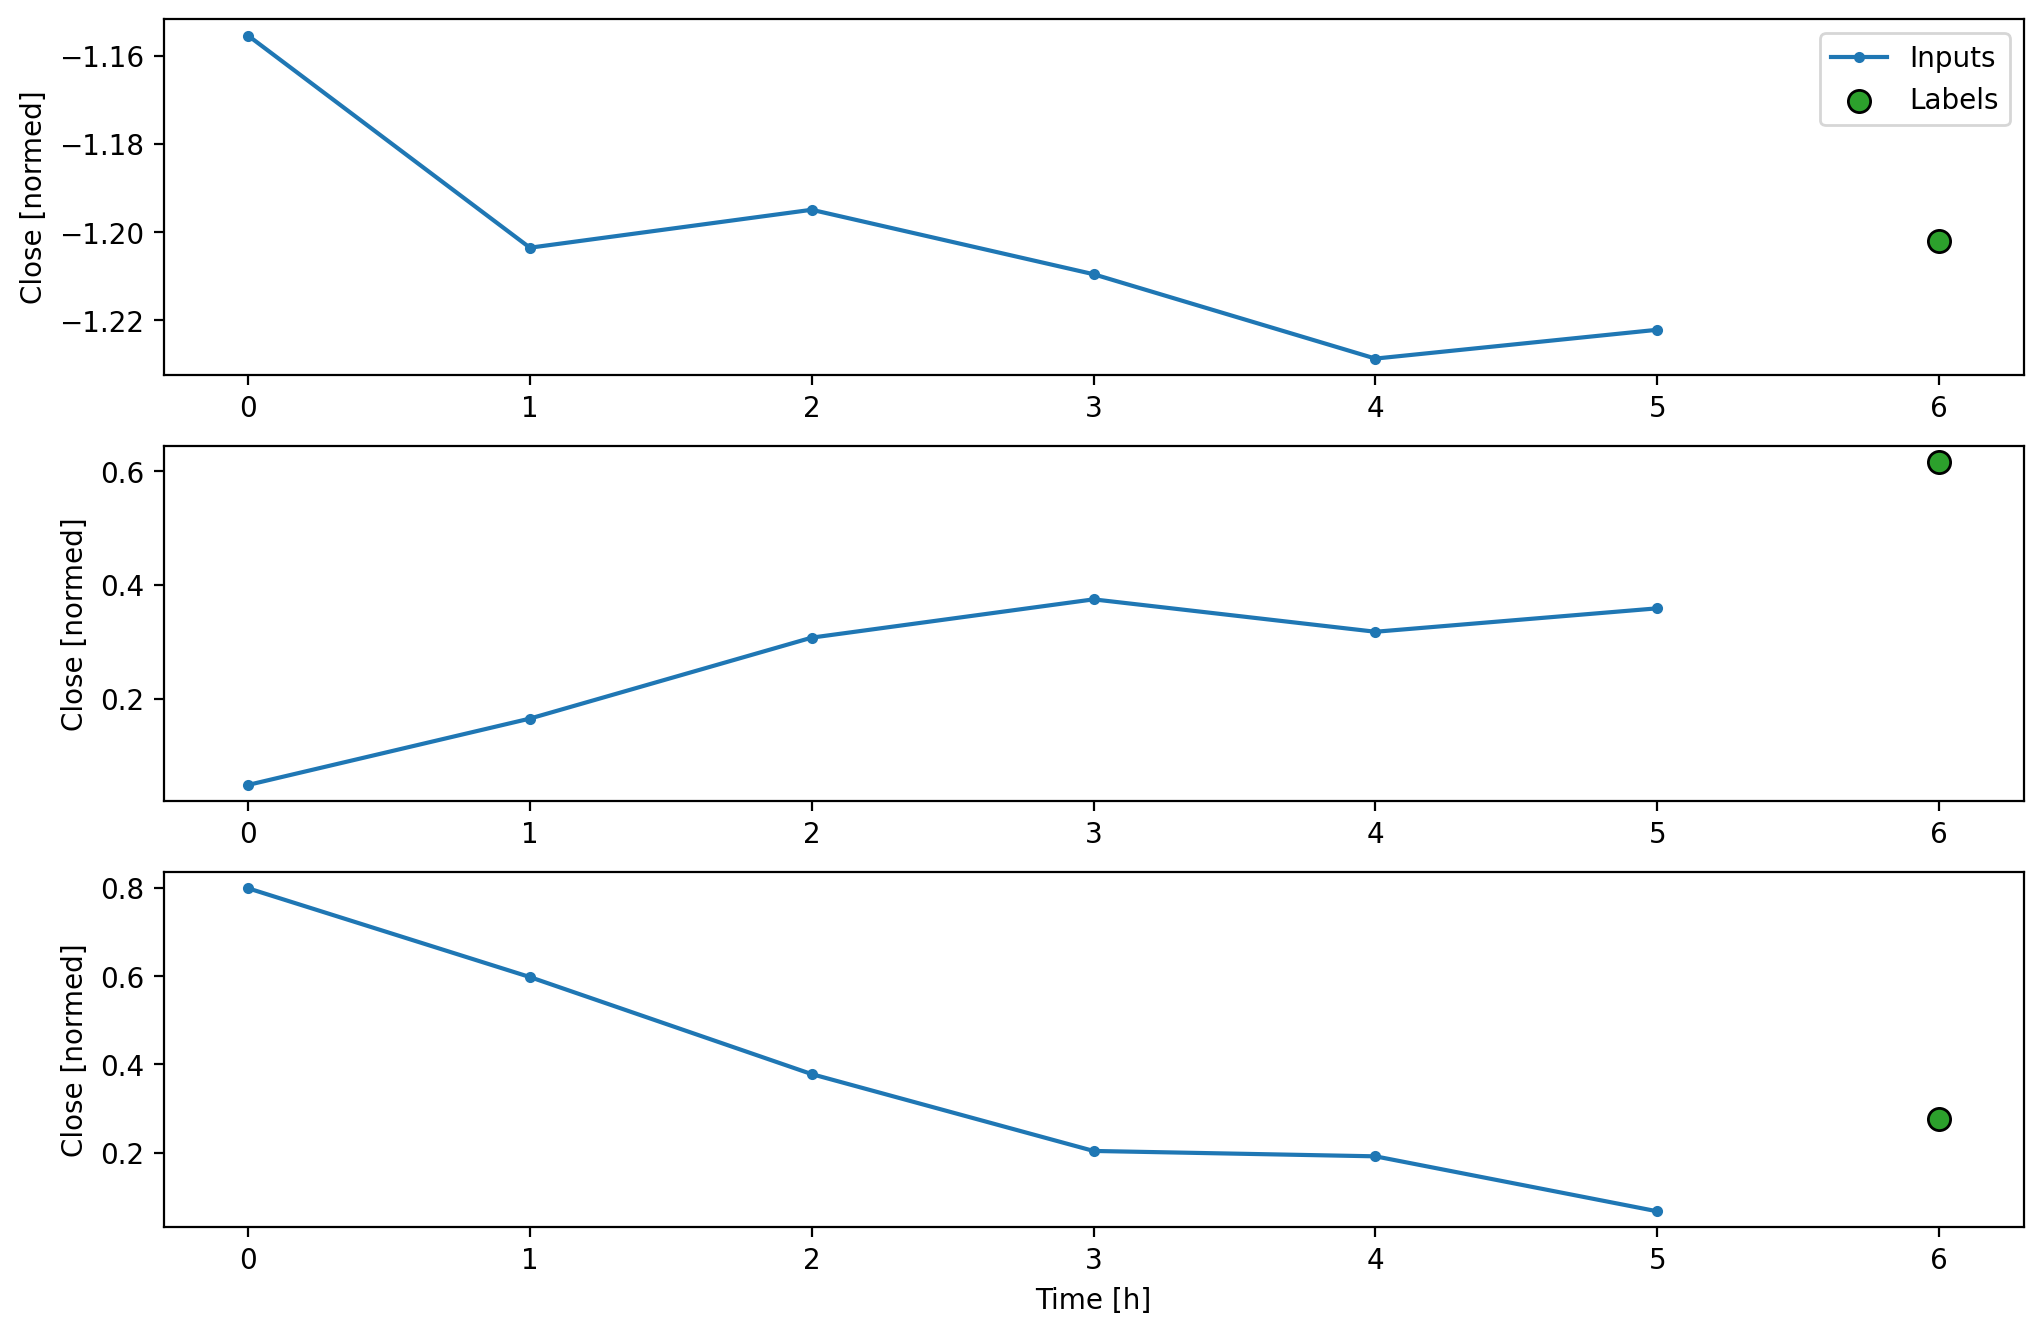

In [211]:
w.plot()

In [212]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data= data, 
        targets=None, 
        sequence_length=self.total_window_size, 
        sequence_stride=1,  
        shuffle=False, 
        batch_size=32)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [213]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [214]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=patience, 
                                             mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(), 
                  optimizer=tf.optimizers.Adam(), 
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, 
                        validation_data=window.val, 
                        callbacks=[early_stopping])
    
    return history

In [215]:
lstm_model = tf.keras.models.Sequential([
    layers.LSTM(256, return_sequences=True),
    layers.Dropout(0.3),
    layers.Dense(units=64),
    layers.Dropout(0.3),
    layers.Dense(units=1)
])

In [216]:
bitcoin_window = WindowGenerator(input_width=13, label_width=13, shift=1, label_columns=['Close'])

In [217]:
print('Input shape:', bitcoin_window.example[0].shape)
print('Output shape:', lstm_model(bitcoin_window.example[0]).shape)

Input shape: (32, 13, 5)
Output shape: (32, 13, 1)


In [218]:
val_performance = {}
performance = {}

In [219]:
history = compile_and_fit(lstm_model, bitcoin_window, patience=5)

val_performance['LSTM'] = lstm_model.evaluate(bitcoin_window.val)
performance['LSTM'] = lstm_model.evaluate(bitcoin_window.test, verbose=0)

Epoch 1/50


2022-06-13 11:13:07.481633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-13 11:13:07.872728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-13 11:13:08.459324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - ETA: 0s - loss: 0.2070 - mean_absolute_error: 0.3126

2022-06-13 11:13:10.277193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-13 11:13:10.355705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 4s 51ms/step - loss: 0.2070 - mean_absolute_error: 0.3126 - val_loss: 14.3716 - val_mean_absolute_error: 2.9476
Epoch 2/50
39/39 [==============================] - 1s 21ms/step - loss: 0.0831 - mean_absolute_error: 0.1958 - val_loss: 12.4214 - val_mean_absolute_error: 2.8270
Epoch 3/50
39/39 [==============================] - 1s 24ms/step - loss: 0.1480 - mean_absolute_error: 0.2491 - val_loss: 16.9024 - val_mean_absolute_error: 3.6219
Epoch 4/50
39/39 [==============================] - 1s 21ms/step - loss: 0.0545 - mean_absolute_error: 0.1571 - val_loss: 8.1648 - val_mean_absolute_error: 2.3190
Epoch 5/50
39/39 [==============================] - 1s 22ms/step - loss: 0.0392 - mean_absolute_error: 0.1336 - val_loss: 6.1329 - val_mean_absolute_error: 1.9767
Epoch 6/50
39/39 [==============================] - 1s 21ms/step - loss: 0.0325 - mean_absolute_error: 0.1222 - val_loss: 5.7762 - val_mean_absolute_error: 1.9418
Epoch 7/50
39/39 [============

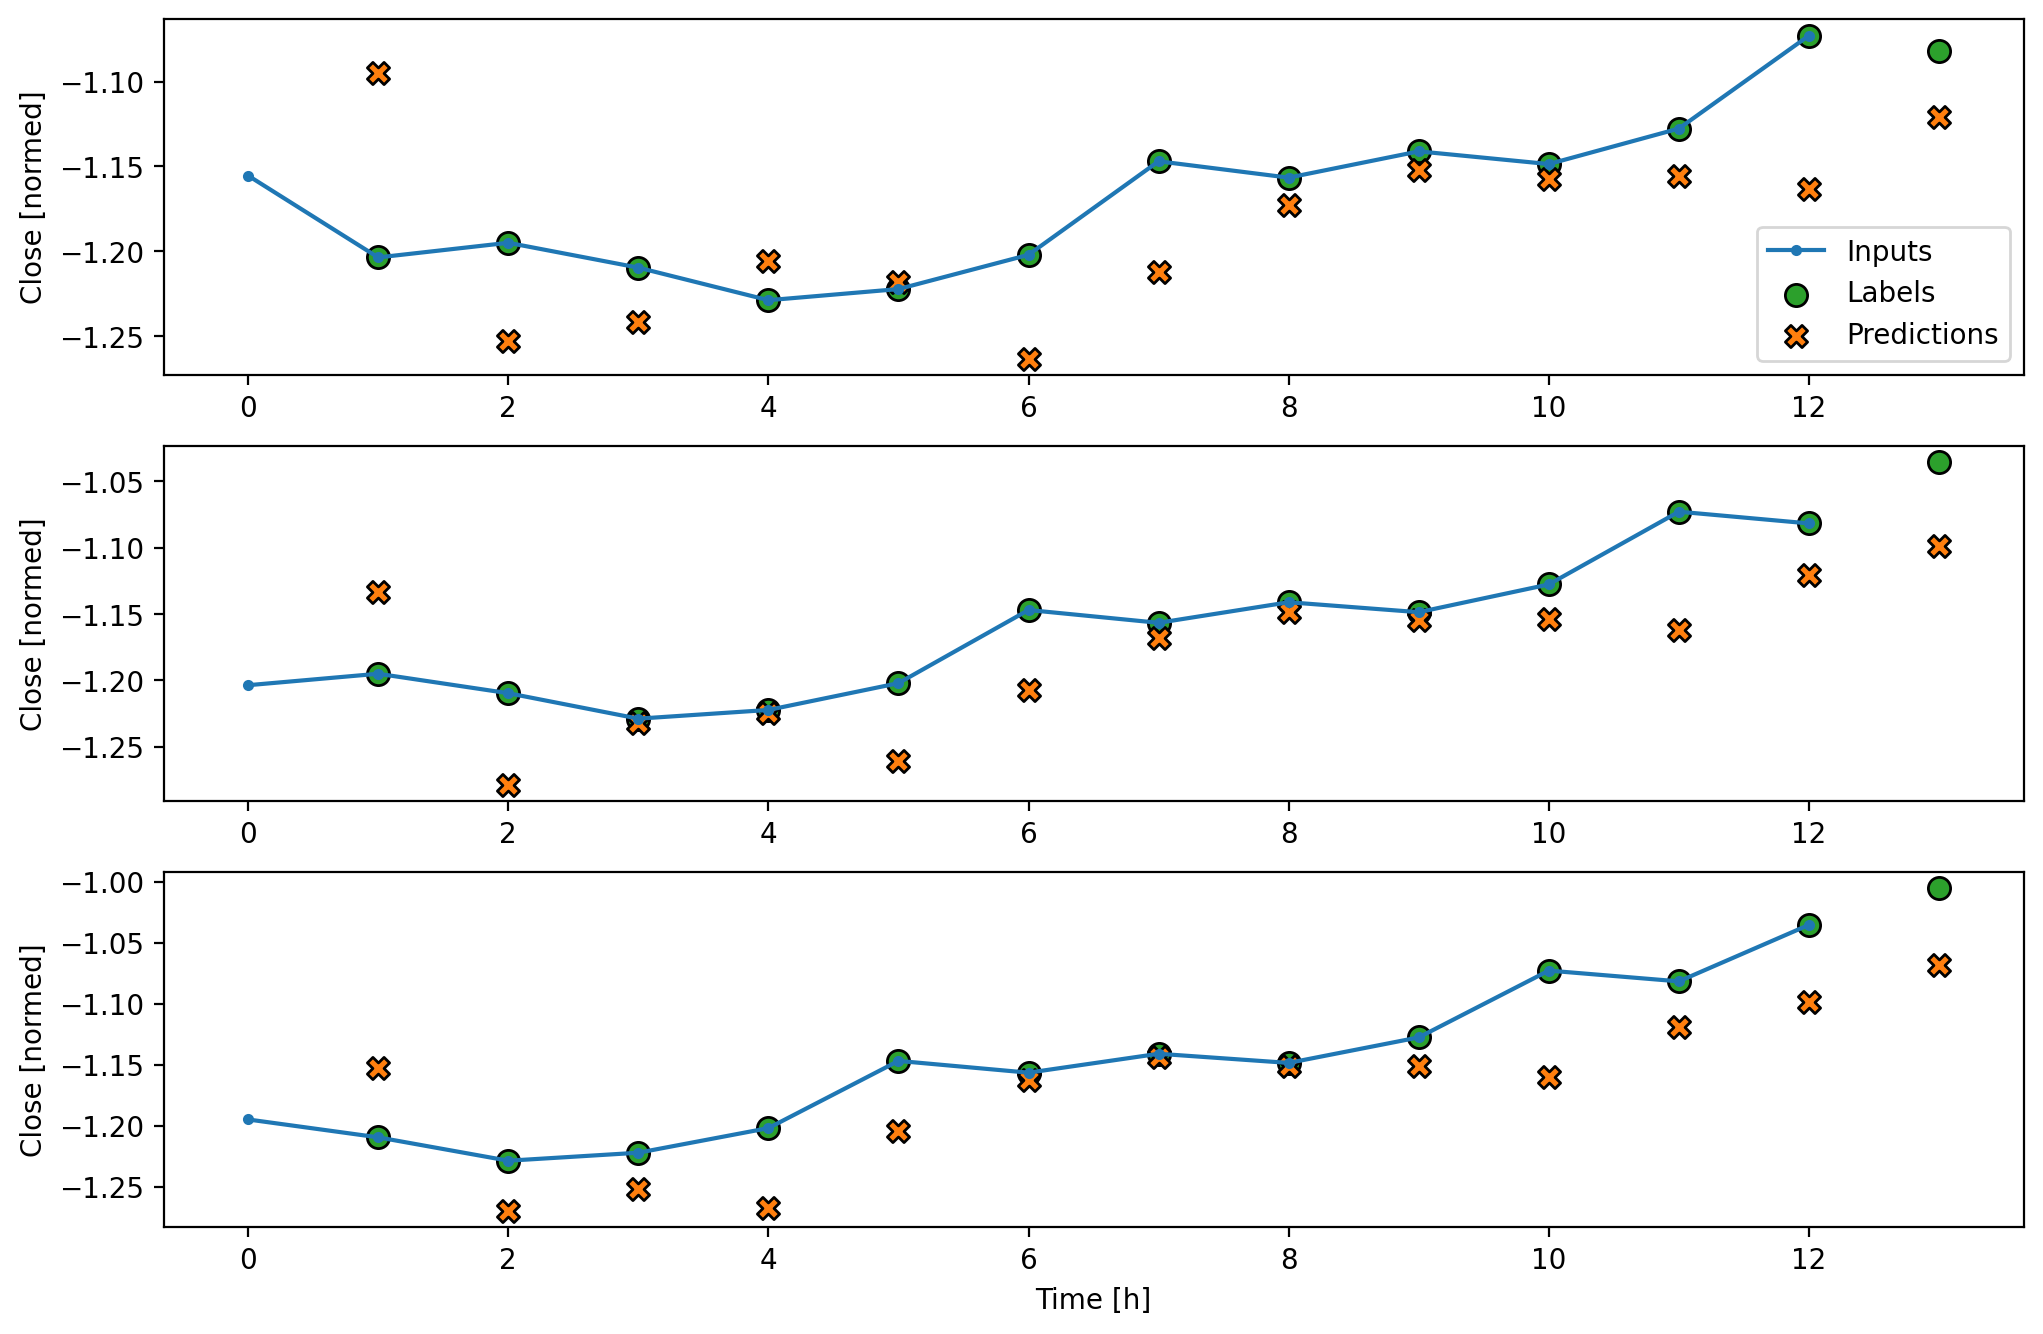

In [220]:
bitcoin_window.plot(lstm_model)

In [221]:
performance

{'LSTM': [0.7810627222061157, 0.7192995548248291]}

In [222]:
val_performance

{'LSTM': [4.326440811157227, 1.6751658916473389]}

In [223]:
predictions = lstm_model.predict(bitcoin_window.test)

1/6 [====>.........................] - ETA: 1s

2022-06-13 11:13:27.883953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-13 11:13:27.963271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 17ms/step


In [257]:
predictions

array([[[8.194172 ],
        [8.635695 ],
        [9.010598 ],
        ...,
        [9.963652 ],
        [9.524429 ],
        [9.3485565]],

       [[8.189469 ],
        [8.723197 ],
        [8.944672 ],
        ...,
        [9.515229 ],
        [9.341129 ],
        [9.381024 ]],

       [[8.239195 ],
        [8.658451 ],
        [9.22678  ],
        ...,
        [9.331387 ],
        [9.37314  ],
        [9.309992 ]],

       ...,

       [[5.5345397],
        [5.397296 ],
        [5.4833903],
        ...,
        [5.880738 ],
        [6.167329 ],
        [6.1274605]],

       [[5.4746284],
        [5.397274 ],
        [5.5792146],
        ...,
        [6.1632648],
        [6.124127 ],
        [6.042282 ]],

       [[5.470136 ],
        [5.5004034],
        [6.027698 ],
        ...,
        [6.119781 ],
        [6.0393295],
        [5.9850154]]], dtype=float32)

In [260]:
for i in bitcoin_window.test:
    print(i[0].shape, i[1].shape)
    break
len(bitcoin_window.test)
len(test_df) / 32
for i in bitcoin_window.test.take(-1):
    print(i[0])

(32, 13, 5) (32, 13, 1)
tf.Tensor(
[[[10.776238   10.393662   10.702215   10.252104   -0.04188264]
  [10.36352    10.233796   10.714864   10.443822   -0.57963884]
  [10.556484   10.474192   10.97557    10.402045   -0.45220125]
  ...
  [11.641885   11.477471   12.137531   11.497979   -0.46772727]
  [11.621493   11.110921   11.236042   10.637171    0.03985676]
  [10.751826   10.431568   10.886477   10.343007   -0.14909883]]

 [[10.36352    10.233796   10.714864   10.443822   -0.57963884]
  [10.556484   10.474192   10.97557    10.402045   -0.45220125]
  [10.514283   10.272254   10.731781   10.465544   -0.25764546]
  ...
  [11.621493   11.110921   11.236042   10.637171    0.03985676]
  [10.751826   10.431568   10.886477   10.343007   -0.14909883]
  [10.454635   10.368246   10.82985    10.5218935  -0.42108005]]

 [[10.556484   10.474192   10.97557    10.402045   -0.45220125]
  [10.514283   10.272254   10.731781   10.465544   -0.25764546]
  [10.578435   10.746717   11.0397     11.004137   -0

In [262]:
predictions

array([[[8.194172 ],
        [8.635695 ],
        [9.010598 ],
        ...,
        [9.963652 ],
        [9.524429 ],
        [9.3485565]],

       [[8.189469 ],
        [8.723197 ],
        [8.944672 ],
        ...,
        [9.515229 ],
        [9.341129 ],
        [9.381024 ]],

       [[8.239195 ],
        [8.658451 ],
        [9.22678  ],
        ...,
        [9.331387 ],
        [9.37314  ],
        [9.309992 ]],

       ...,

       [[5.5345397],
        [5.397296 ],
        [5.4833903],
        ...,
        [5.880738 ],
        [6.167329 ],
        [6.1274605]],

       [[5.4746284],
        [5.397274 ],
        [5.5792146],
        ...,
        [6.1632648],
        [6.124127 ],
        [6.042282 ]],

       [[5.470136 ],
        [5.5004034],
        [6.027698 ],
        ...,
        [6.119781 ],
        [6.0393295],
        [5.9850154]]], dtype=float32)